In [1]:
import torch

from pathlib import Path

from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed

from modular_transformers.models.gpt2.configuration_gpt2 import GPT2Config
from modular_transformers.models import components

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

from tqdm import tqdm

import subprocess
import os
import gc

#set seeds
torch.manual_seed(0)
np.random.seed(0)
set_seed(0)

#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#set tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Prep

In [ ]:
def load_data(num_bigrams):
    bigram_text = open("bigrams.txt", "r").read().split("\n")
    bigrams = [(int(b[b.find('\t')+1:]), b[:b.find('\t')]) for b in bigram_text if len(b) > 0]
    bigrams.sort(key=lambda x: x[0], reverse=True)
    bigrams = bigrams[:num_bigrams]

    bigram_tokens = [tokenizer.encode(b[1]) for b in bigrams]
    # bigram_tokens = [b + [tokenizer.pad_token_id]*(max_token_num-len(b)) for b in bigram_tokens]
    bigram_tokens = [torch.tensor(b) for b in bigram_tokens]
    # bigram_tokens = torch.cat(bigram_tokens, dim=0)
    return bigram_tokens


In [ ]:
def load_model(model_path = "gpt2"):
    if model_path == "gpt2":
        orig_model = GPT2LMHeadModel.from_pretrained("gpt2")
    else:
        orig_model = components.LM.from_pretrained(model_path)
    return orig_model.to(device)

In [ ]:
# code for loading a custom model (untrained)
# bottleneck_dim = 4
# n_layer = 12

# config = {'vocab_size': len(tokenizer), 'n_ctx': 1024, 'bos_token_id': tokenizer.bos_token_id,
#                     'eos_token_id': tokenizer.eos_token_id, "bottleneck": bottleneck_dim, "n_layer": n_layer}
# config = GPT2Config(config)
# config.n_embds = []
# orig_model = components.LM(config)
# orig_model.to(device)

### 2. Data collection

#### recording the neural network activations

In [ ]:
class Activations():
    def __init__(self, num_layers, max_token_num):
        self.activations = [[[] for _ in range(num_layers)] for _ in range(max_token_num)]
    
    def register_monitoring_hooks(self, model, max_token_num):
        def hook_wrapper(layer):
            def hook_function(module, input, output):
                input = input[0]
                for i in range(min(max_token_num, input.shape[1])):
                    self.activations[i][layer].append(input[:, i, :].detach().cpu())
            return hook_function

        for i, layer in enumerate(model.transformer.h):
            # layer.mlp.c_proj.register_forward_hook(hook_wrapper(i))
            # layer.attn.c_attn.register_forward_hook(hook_wrapper(i))
            layer.ln_2.register_forward_hook(hook_wrapper(i))

def make_activation_matrix(activations, max_token_num, num_layers):
    final = [[[] for _ in range(num_layers)] for _ in range(max_token_num)]
    for token_num, acts in enumerate(activations):
        if len(acts[0]) < 2:
            final = final[:token_num]
            max_token_num = token_num
            break
        for layer, layer_acts in enumerate(acts):
            matrix = torch.stack(layer_acts, dim=0).squeeze()
            final[token_num][layer] = matrix
    return final, max_token_num

def get_activation_matrix(model, bigram_tokens, max_token_num, num_layers):
    """
    :param model: model to get activations from
    :param bigram_tokens: list of bigram tokens
    :param max_token_num: max number of tokens in bigrams
    :param num_layers: number of layers in model
    :return: activation matrix: token_num: layer: activations (num_bigrams x hidden_size)
    """
    activation_class = Activations(num_layers, max_token_num)
    activation_class.register_monitoring_hooks(model, max_token_num)

    logits = []
    for bigram in tqdm(bigram_tokens):
        input = bigram.to(device)
        output = model(input)
        input.detach_()
        logits.append(output.logits[-1, :])
    logits = torch.stack(logits, dim=0)
    logits.detach_()
    activations = activation_class.activations

    activations, max_token_num = make_activation_matrix(activations, max_token_num, num_layers)

    return activations, max_token_num, logits

#### Find principal axes to perturb along

In [ ]:
def get_pcas(activations, num_layers, max_token_num):
    pcas = [[None for _ in range(num_layers)] for _ in range(max_token_num)]
    for token_num, acts in enumerate(activations):
        for layer, matrix in enumerate(acts):
            pca = PCA()
            if not isinstance(matrix, list):
                matrix = matrix.detach().cpu().numpy()
            else:
                matrix = np.array(matrix).reshape(1, -1)
            pca.fit(matrix)
            pcas[token_num][layer] = pca
    return pcas

#find the number of components needed to explain a baseline variance as well as a universal cutoff
def get_num_components(orig_pcas, max_token_num, pca_dim, num_layers):
    num_components = [[{} for _ in range(num_layers)] for _ in range(max_token_num)]
    for token_num, layers_pcas in enumerate(orig_pcas):
        for layer, pca in enumerate(layers_pcas):
            variance = pca.explained_variance_ratio_
            for i, v in enumerate(variance.cumsum()):
                if v > 0.8:
                    num_components[token_num][layer]["explained_cutoff"] = i
                    break
            if len(variance) < pca_dim:
                num_components[token_num][layer]["cutoff"] = len(variance)
            else:
                num_components[token_num][layer]["cutoff"] = pca_dim
                
    return num_components

#### plot top two principal components on scatter plot and plot explained variance curve

In [ ]:
def plot_pca(token_num, activations, pcas):
    ax, fig = plt.subplots(figsize=(16, 13), nrows=4, ncols=6)
    for layer, pca in enumerate(pcas):

        data = pca.transform(activations[token_num][layer].detach().cpu().numpy())
        variance = pca.explained_variance_ratio_

        #visualize components
        fig[(layer*2)//6, (layer*2)%6].scatter(data[:, 0], data[:, 1])
        fig[(layer*2)//6, (layer*2)%6].set_title(f'Layer {layer}')

        #visualize variance with cumulative sum
        fig[(layer*2)//6, (layer*2)%6 + 1].plot(range(len(variance)), variance.cumsum())
        fig[(layer*2)//6, (layer*2)%6 + 1].set_ylim(0, 1)
        fig[(layer*2)//6, (layer*2)%6 + 1].set_title(f'Layer {layer}')

    plt.show()

def plot_pcas(pcas, activations):
    for token_num, pca in enumerate(pcas):
        print(f'Token {token_num}')
        plot_pca(token_num, activations, pca)

### Perturb along principal axes

In [ ]:
def get_orthogonal_vector(v):
    if np.all(v == 0):
        raise ValueError("The input vector cannot be the zero vector.")

    # Create a matrix with the input vector as the first row
    # and fill the rest with random values
    A = np.vstack([v, np.random.rand(len(v)-1, len(v))])

    # Use the null space to find a vector orthogonal to the input vector
    u = np.linalg.svd(A)[2][-1]

    return u

In [ ]:
def register_pertubation_hooks(model, orig_pcas, num_components, pertubation_func, max_token_num, pertubation_layers):
    def hook_wrapper(pcs):
        def prehook(module, input):
            for i in range(min(max_token_num, input[0].shape[1], len(pcs))):
                pc_info = pcs[i]
                pc = pc_info[0]
                orthog_pc = pc_info[1]
                detached_input = input[0][:, i, :].detach().cpu().numpy()
                pertubation = pertubation_func(pc, detached_input, orthog_pc).to(device)
                input[0][:, i, :] += pertubation
                pertubation.detach_()
            return input
        return prehook

    #shuffle for different indexing
    reshuffled_pcas = {layer: {} for layer in pertubation_layers}
    for token_num, layers_pcas in enumerate(orig_pcas):
        for layer, pca in enumerate(layers_pcas):
            if layer in pertubation_layers:
                reshuffled_pcas[layer][token_num] = pca
    
    for layer, layer_pcas in reshuffled_pcas.items():
        pcs = []
        #for ever token num in the layer, find the average of the top num_components components
        for token_num, pca in layer_pcas.items():
            nc = num_components[token_num][layer]["cutoff"]
            pc = pca.components_[:nc, :]
            pc = pc.sum(axis=0) / nc
            pc = pc / np.linalg.norm(pc)
            orthog = get_orthogonal_vector(pc)
            pcs.append((pc, orthog))
        model.transformer.h[layer].mlp.dropout.register_forward_pre_hook(hook_wrapper(pcs))


#### visualize perturbed activations next to original activations

In [ ]:
#visualize
def plot_pca_sidebyside(token_num, orig_pcas, perturbed_pcas, orig_activations, perturbed_activations):
    ax, fig = plt.subplots(figsize=(16, 13), nrows=4, ncols=6)
    for layer, (orig_pca, perturbed_pca) in enumerate(zip(orig_pcas, perturbed_pcas)):

        orig_data = orig_pca.transform(orig_activations[token_num][layer].detach().cpu().numpy())
        perturbed_data = perturbed_pca.transform(perturbed_activations[token_num][layer].detach().cpu().numpy())

        #visualize orig components
        fig[(layer*2)//6, (layer*2)%6].scatter(orig_data[:, 0], orig_data[:, 1])
        fig[(layer*2)//6, (layer*2)%6].set_title(f'Original Layer {layer}')

        #visualize perturbed components
        fig[(layer*2)//6, (layer*2)%6 + 1].scatter(perturbed_data[:, 0], perturbed_data[:, 1])
        fig[(layer*2)//6, (layer*2)%6 + 1].set_title(f'Perturbed Layer {layer}')

    plt.show()

def plot_pca_sidebyside_wrapper(orig_pcas, perturbed_pcas, orig_activations, perturbed_activations):
    for i in range(len(orig_pcas)):
        print(f'Token {i}')
        plot_pca_sidebyside(i, orig_pcas[i], perturbed_pcas[i], orig_activations, perturbed_activations)

In [ ]:
def sample_outputs(models, token_selection, bigram_tokens):
    random_bigram_selection = [bigram_tokens[i] for i in token_selection]
    for bigram in random_bigram_selection:
        for model in models:
            input = bigram.to(device)
            output = model(input)
            prediction = output.logits[-1, :].argmax(dim=-1)
            tokenized = tokenizer.decode(prediction)
            print(tokenizer.decode(bigram.squeeze()) + "->" + tokenized)

### 3. Analyze perturbed activations

In [ ]:
def complete_bigrams(model, bigrams):
    completions = []
    for bigram in bigrams:
        input = torch.tensor(tokenizer.encode(bigram)).to(device)
        output = model(input)
        prediction = output.logits[-1, :].argmax(dim=-1)
        tokenized = tokenizer.decode(prediction)
        completions.append(tokenized)
    return completions

#### analysis functions

In [ ]:
def cosine_divergence(act1, act2):
    cosine_difs = torch.nn.functional.cosine_similarity(act1, act2)
    return cosine_difs.mean().item()

def distance_divergence(act1, act2):
    difference = act1 - act2
    dist = torch.norm(difference, p=2, dim=1).mean()
    return dist.item()

def get_KL_logit_divergence(perturbed_logits, orig_logits):
    KL_divergence = torch.nn.functional.kl_div(torch.nn.functional.log_softmax(perturbed_logits, dim=-1), torch.nn.functional.softmax(orig_logits, dim=-1), reduction='batchmean')
    return KL_divergence.item()

### 4. Main code for creating datasets

In [ ]:
import subprocess

def get_gpu_memory_usage():
    try:
        result = subprocess.check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader'], encoding='utf-8')
        # Convert the output into a list of integers for each GPU
        memory_usage = [int(x) for x in result.strip().split('\n')]
        return memory_usage
    except subprocess.CalledProcessError as e:
        print("Failed to run nvidia-smi: ", e)
        return []

In [ ]:
def go(bigram_tokens, max_token_num, model_path, orig_activations, orig_pcas, orig_logits, pca_dim, pertubation_func, pertubation_size, perturbation_loc, name):
    layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11]
    # name = "random"
    act_save_path = f"/om2/user/jackking/MyData/dynamics/activations/{perturbation_loc}/perturb_{pertubation_size}/{name}"
    save_path = f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{perturbation_loc}/perturb_{pertubation_size}/{name}"
    if not os.path.exists(act_save_path):
        # Create the directory if it does not exist
        os.makedirs(act_save_path)
    if not os.path.exists(save_path):
        # Create the directory if it does not exist
        os.makedirs(save_path)

    bigram_results_df = pd.read_csv('/om2/user/jackking/modular_transformers/modular_transformers/dynamics/bigram_results.csv', index_col=0)
    test_bigrams = bigram_results_df['bigram'].tolist()

    bigram_results_df = pd.DataFrame(columns=['bigram'] + [layer for layer in layers])
    bigram_results_df['bigram'] = test_bigrams

    column_names = ["layer_num"] + ["cosine_lyapunov", "distance_lyapunov", "KL_logit_div"] + [f"cosine_sim_{i}" for i in layers] + [f"distance_{i}" for i in layers] 
    dataframes = [pd.DataFrame(columns=column_names) for _ in range(max_token_num)]

    # dataframes = [pd.read_csv(f'{save_path}/token_{token_num}_results_df.csv', index_col=0) for token_num in range(max_token_num)]

    for layer in layers:
        torch.cuda.empty_cache() 
        print(f'Running layer {layer}')
        gpu_memory_usage = get_gpu_memory_usage()
        print("GPU Memory Usage (in MB):", gpu_memory_usage)
        print(torch.cuda.memory_allocated())

        perturbed_model = load_model(model_path)
        num_layers = len(perturbed_model.transformer.h)
        num_components = get_num_components(orig_pcas, max_token_num, pca_dim, num_layers)

        register_pertubation_hooks(perturbed_model, orig_pcas, num_components, pertubation_func, max_token_num, [layer])
        perturbed_activations, max_token_num, perturbed_logits = get_activation_matrix(perturbed_model, bigram_tokens, max_token_num, num_layers)

        torch.save(perturbed_activations, f'{act_save_path}/{layer}_perturbed_activations.pt')

        completions = complete_bigrams(perturbed_model, test_bigrams)
        bigram_results_df[layer] = completions
        del perturbed_model
        gc.collect()
        torch.cuda.empty_cache() 

        KL_logit_div = get_KL_logit_divergence(perturbed_logits, orig_logits)

        for token_num in range(max_token_num):
            print(f'Running token {token_num}')
            if not layer == 11:
                cosine_difs = []
                distances = []
                for compare_layer in layers[layer+1:]:
                    cosine_dif = 1 - cosine_divergence(orig_activations[token_num][compare_layer], perturbed_activations[token_num][compare_layer])
                    distance = distance_divergence(orig_activations[token_num][compare_layer], perturbed_activations[token_num][compare_layer])
                    cosine_difs.append(cosine_dif)
                    distances.append(distance)
                cosine_lyapunov = np.log(np.abs(np.array(cosine_difs) + 1e-9 / pertubation_size)).sum() / len(cosine_difs)
                distance_lyapunov = np.log(np.array(distances) + 1e-9 / pertubation_size).sum() / len(distances)
                
                df = dataframes[token_num]
                new_df = pd.DataFrame({
                    "layer_num": [layer],
                    "cosine_lyapunov": [cosine_lyapunov],
                    "distance_lyapunov": [distance_lyapunov],
                    "KL_logit_div": [KL_logit_div],
                    **{f"cosine_sim_{i}": [cosine_difs[i - (layer + 1)]] for i in layers[layer+1:]},
                    **{f"distance_{i}": [distances[i - (layer + 1)]] for i in layers[layer+1:]}
                })
            else:
                df = dataframes[token_num]
                new_df = pd.DataFrame({
                    "layer_num": [layer],
                    "KL_logit_div": [KL_logit_div],
                })
            df = pd.concat([df, new_df], ignore_index=True)
            dataframes[token_num] = df
        
        for token_num, df in enumerate(dataframes):
            df.to_csv(f'{save_path}/token_{token_num}_results_df.csv')      
        bigram_results_df.to_csv(f'{save_path}/bigram_results.csv')  

def generate_random_pertubation(pertubation_size, pc):
    pertubation = torch.randn(pc.shape)
    pertubation = pertubation / np.linalg.norm(pertubation) * pertubation_size
    return pertubation

#### main

In [ ]:
num_bigrams = 10000
bigram_tokens = load_data(num_bigrams)
max_token_num = max([len(b) for b in bigram_tokens])
model_path = 'gpt2'

orig_model = load_model(model_path)
num_layers = len(orig_model.transformer.h)
orig_activations, max_token_num, orig_logits = get_activation_matrix(orig_model, bigram_tokens, max_token_num, num_layers)
orig_pcas = get_pcas(orig_activations, num_layers, max_token_num)
del orig_model
gc.collect()
torch.cuda.empty_cache() 

pertubation_loc = "before_mlp"

for pertubation_size in [0.01, 1, 10]:
    pca_dim = 1
    pertubation_func = lambda pc, input, orthog_pc: generate_random_pertubation(pertubation_size, pc)
    name = "random"
    go(bigram_tokens, max_token_num, model_path, orig_activations, orig_pcas, orig_logits, pca_dim, pertubation_func, pertubation_size, pertubation_loc, name)

### Plot from datasets

#### plot activations

In [2]:
def plot_lya(perbs, ax, i, layers, perturb_size):
        #make a grid to put plots in
    for name, df in perbs.items():
        ax[i].plot(layers, df["distance_lyapunov"], label=name)
        ax[i].set_title("Average Lyapunov Exponent, Perturbation = " + str(perturb_size))

In [3]:
def plot_log(perbs, ax, i, layers, perturb_size):
        #make a grid to put plots in
    for name, df in perbs.items():
        ax[i].plot(layers, df["KL_logit_div"], label=name)
        ax[i].set_title("KL Divergence Between Logits, Perturbation = " + str(perturb_size))

In [4]:
def twodplot(perbs, perturb_size, layers):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 13))
    for ax, (name, df) in zip(axs.flatten(), perbs.items()):
        new_df = pd.DataFrame(columns=[f"distance_{i}" for i in layers])
        for i in layers:
            new_df[f"distance_{i}"] = np.log(df[f"distance_{i}"] / 0.01)
            #change title of column just to be number
            new_df.rename(columns={f"distance_{i}": i}, inplace=True)
        #heatmap of distances
        sns.heatmap(new_df, ax = ax, cmap="crest", cbar=False)
        ax.set_title(name)
        ax.set_ylabel("Perturbed Layer")

    fig.colorbar(axs[0, 0].get_children()[0], ax=axs, orientation='vertical', fraction=.1)
    fig.suptitle("Lyapunov Exponent Heatmap, Perturbation = " + str(perturb_size))
    plt.show()

In [5]:
def plot_lyapunov(layers, where):
    perturb_sizes = [0.01, 1, 10]
    fig, ax = plt.subplots(figsize=(8, 10), nrows=3, ncols=1)
    for i, perturb_size in enumerate(perturb_sizes):
        
        orthogonal_5pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/orthogonal_5pcs/token_1_results_df.csv", index_col=0)
        orthogonal_20pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/orthogonal_20pcs/token_1_results_df.csv", index_col=0)
        random = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/random/token_1_results_df.csv", index_col=0)
        parallel_5pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/parallel5pcs/token_1_results_df.csv", index_col=0)
        parallel_20pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/parallel20pcs/token_1_results_df.csv", index_col=0)
        perbs = {"orthogonal_5pcs": orthogonal_5pcs, "orthogonal_20pcs": orthogonal_20pcs, "random": random, "parallel_5pcs": parallel_5pcs, "parallel_20pcs": parallel_20pcs}

        plot_lya(perbs, ax, i, layers, perturb_size)

    plt.legend()
    plt.show()

In [6]:
def plot_logit_divergence(layers, where):
    perturb_sizes = [0.01, 1, 10]
    fig, ax = plt.subplots(figsize=(8, 10), nrows=3, ncols=1)
    for i, perturb_size in enumerate(perturb_sizes):
        
        orthogonal_5pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/orthogonal_5pcs/token_1_results_df.csv", index_col=0)
        orthogonal_20pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/orthogonal_20pcs/token_1_results_df.csv", index_col=0)
        random = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/random/token_1_results_df.csv", index_col=0)
        parallel_5pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/parallel5pcs/token_1_results_df.csv", index_col=0)
        parallel_20pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/parallel20pcs/token_1_results_df.csv", index_col=0)
        perbs = {"orthogonal_5pcs": orthogonal_5pcs, "orthogonal_20pcs": orthogonal_20pcs, "random": random, "parallel_5pcs": parallel_5pcs, "parallel_20pcs": parallel_20pcs}

        plot_log(perbs, ax, i, layers, perturb_size)

    plt.legend()
    plt.show()

In [7]:
def plot_heatmap(layers, where):
    perturb_size = [0.01, 1, 10]
    for i, perturb_size in enumerate(perturb_size):

        orthogonal_5pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/orthogonal_5pcs/token_1_results_df.csv", index_col=0)
        orthogonal_20pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/orthogonal_20pcs/token_1_results_df.csv", index_col=0)
        random = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/random/token_1_results_df.csv", index_col=0)
        parallel_5pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/parallel5pcs/token_1_results_df.csv", index_col=0)
        parallel_20pcs = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{perturb_size}/parallel20pcs/token_1_results_df.csv", index_col=0)
        perbs = {"orthogonal_5pcs": orthogonal_5pcs, "orthogonal_20pcs": orthogonal_20pcs, "random": random, "parallel_5pcs": parallel_5pcs, "parallel_20pcs": parallel_20pcs}

        twodplot(perbs, perturb_size, layers)

    plt.show()

PERTUBATION IS IN RESIDUAL BEFORE ATTENTION LAYER


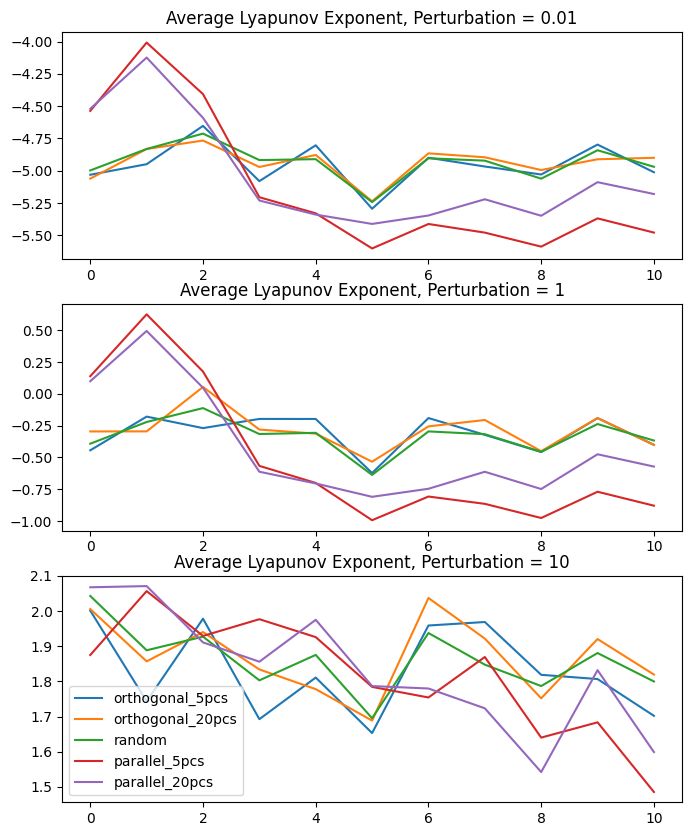

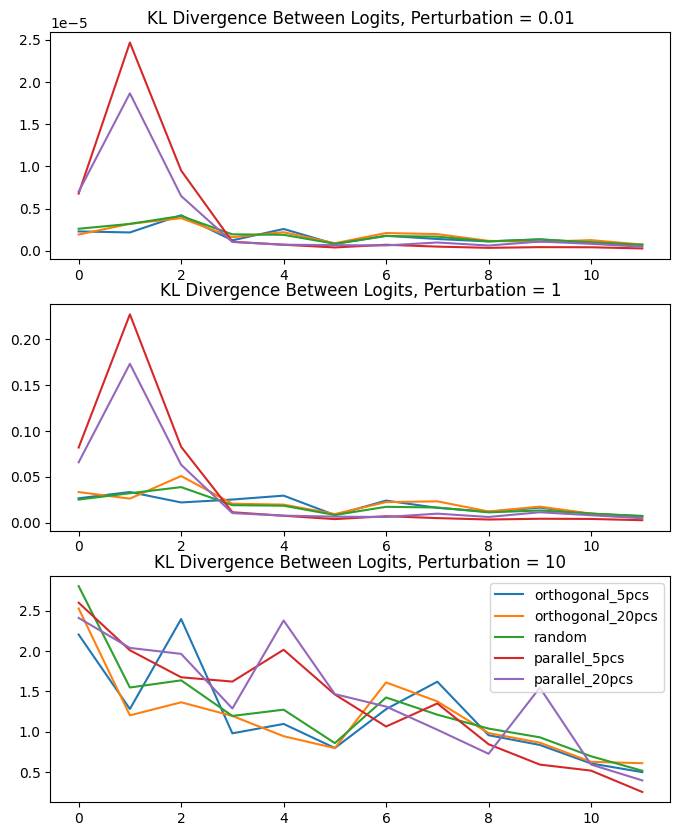

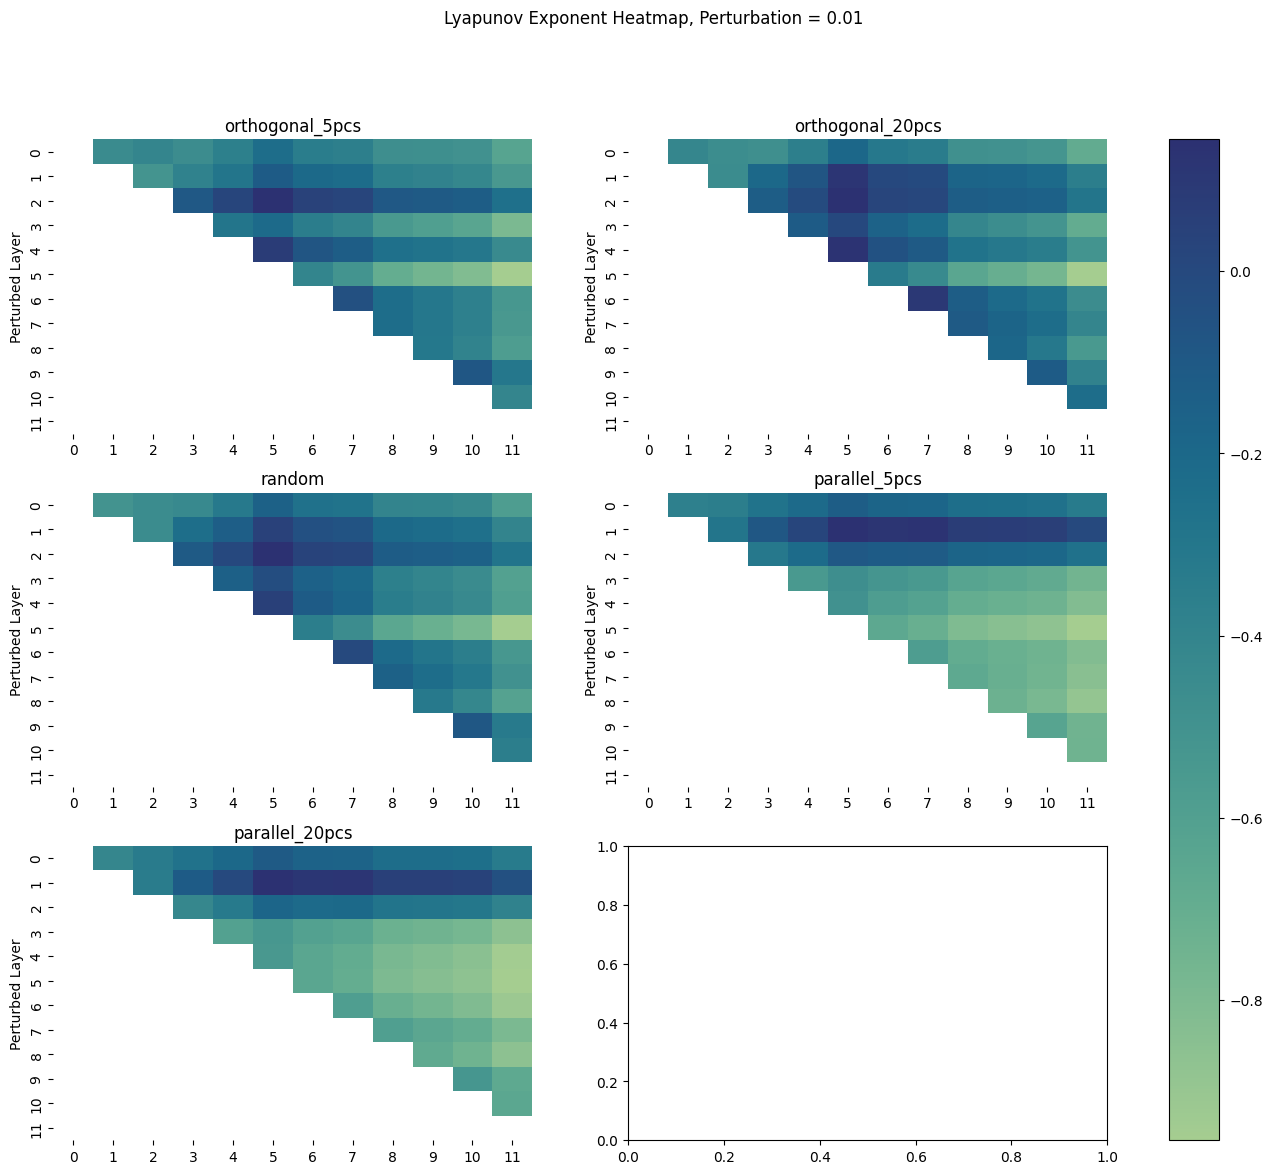

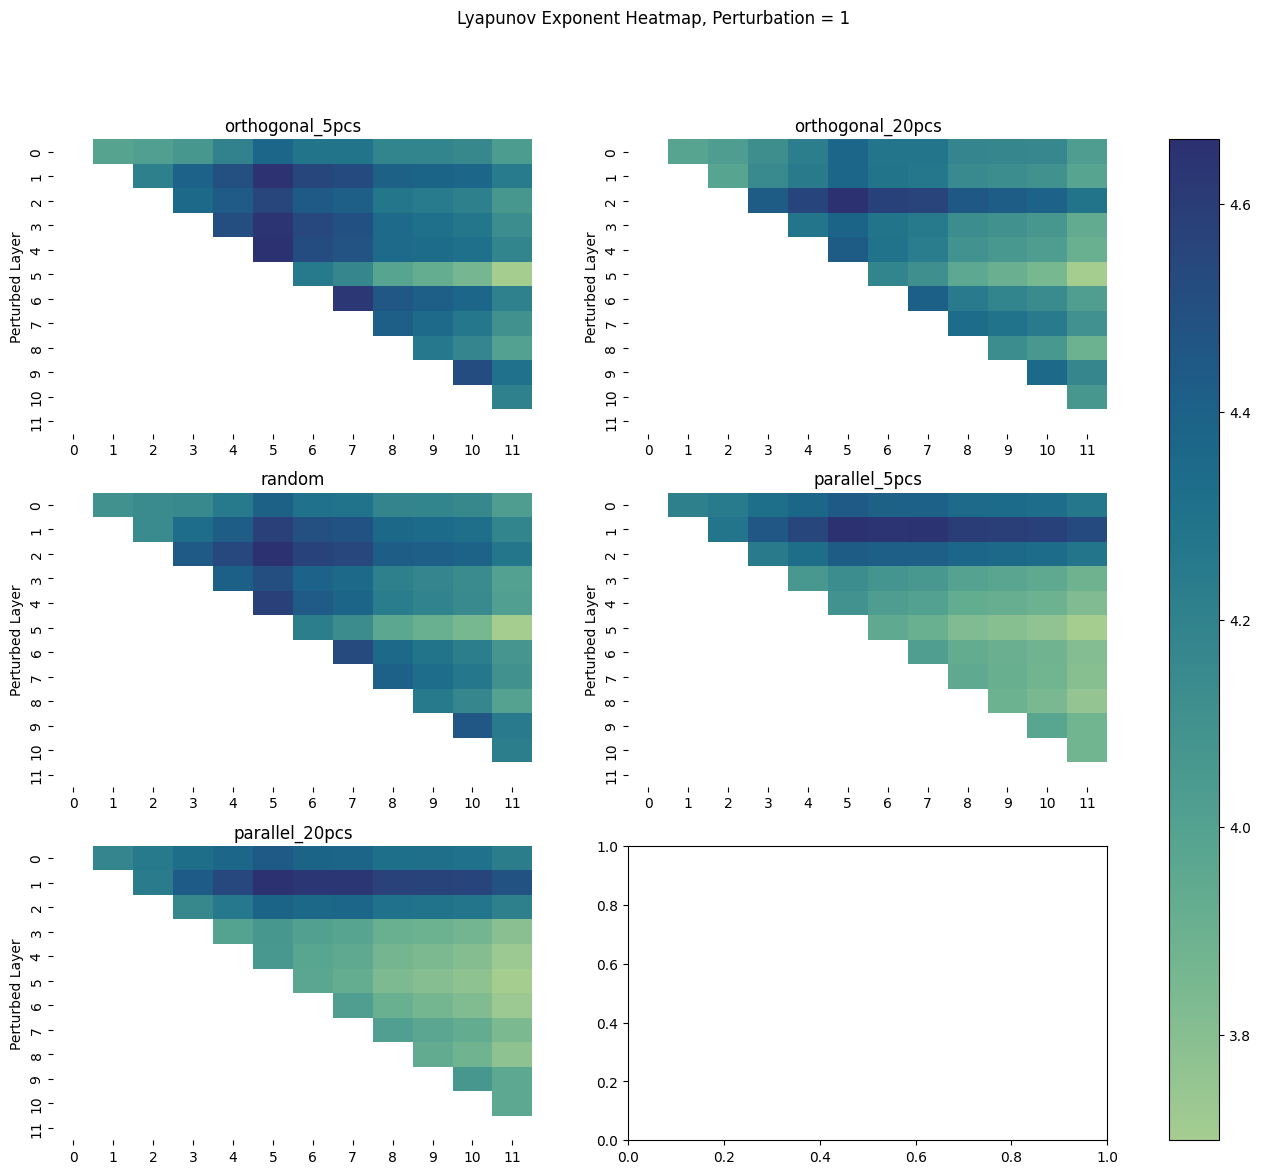

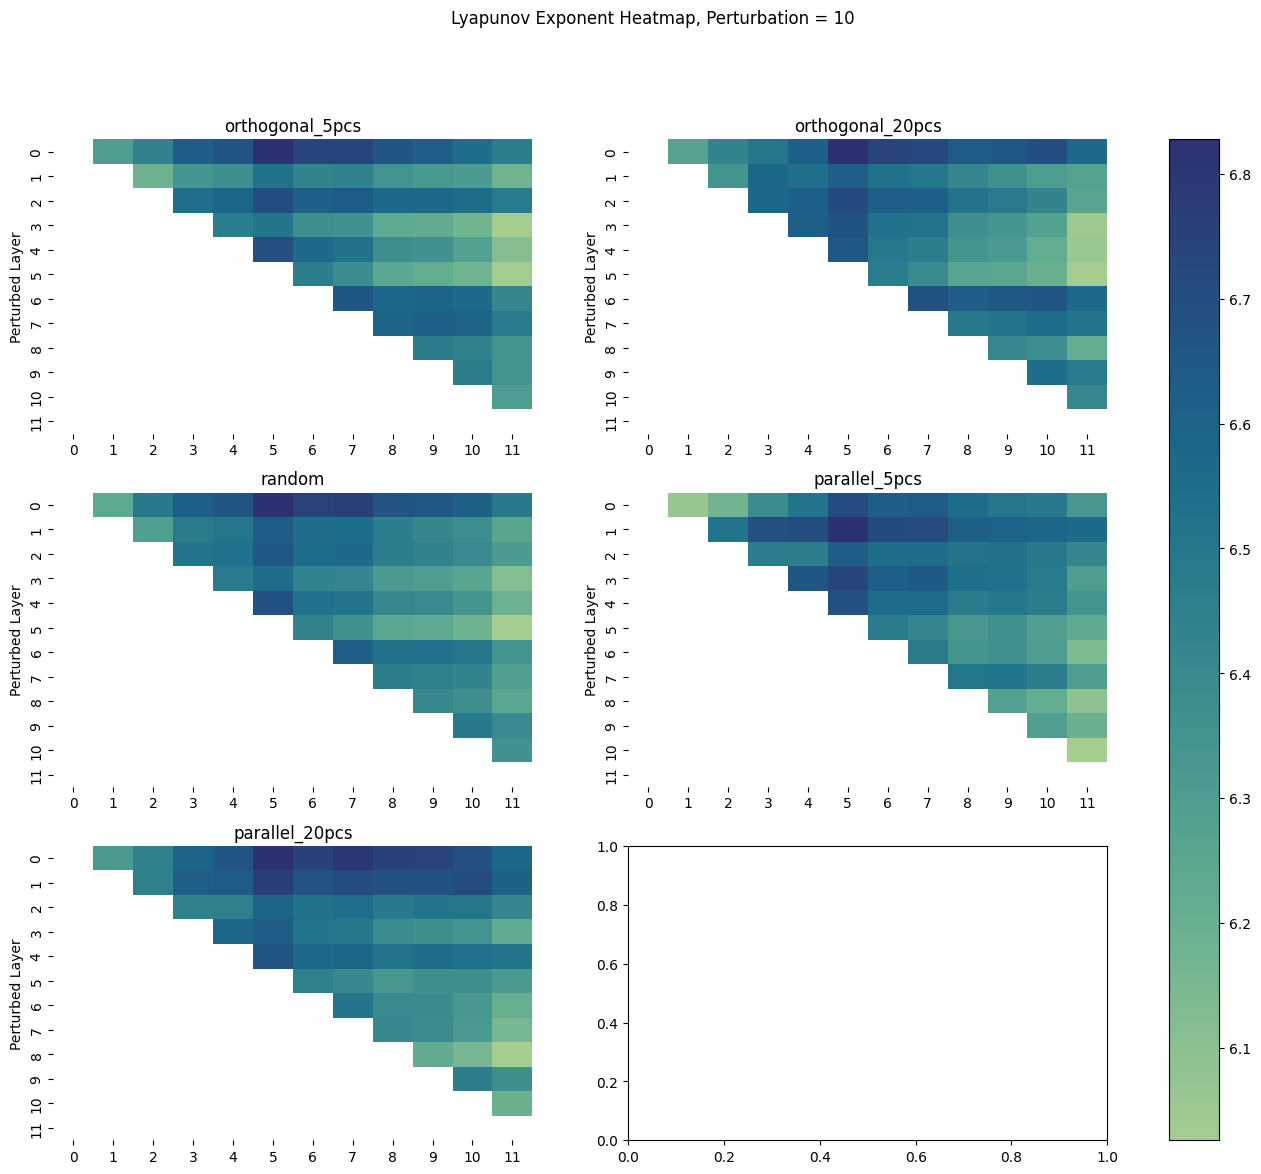

PERTUBATION IS IN RESIDUAL BEFORE MLP LAYER


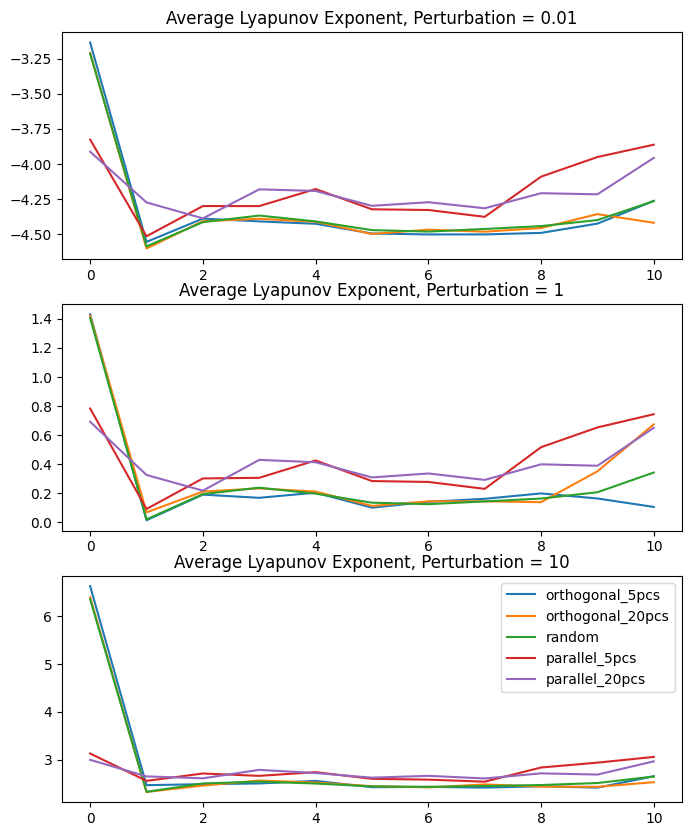

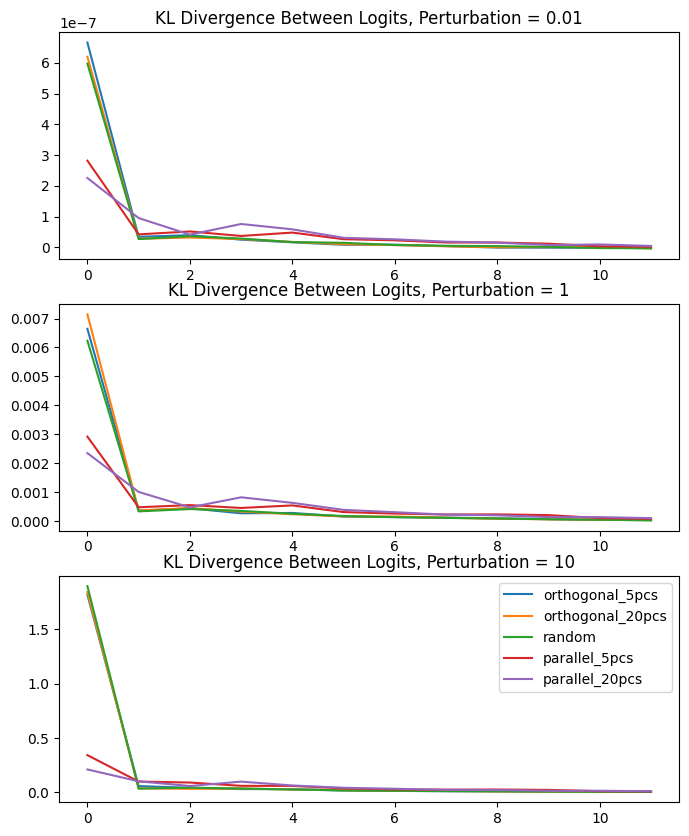

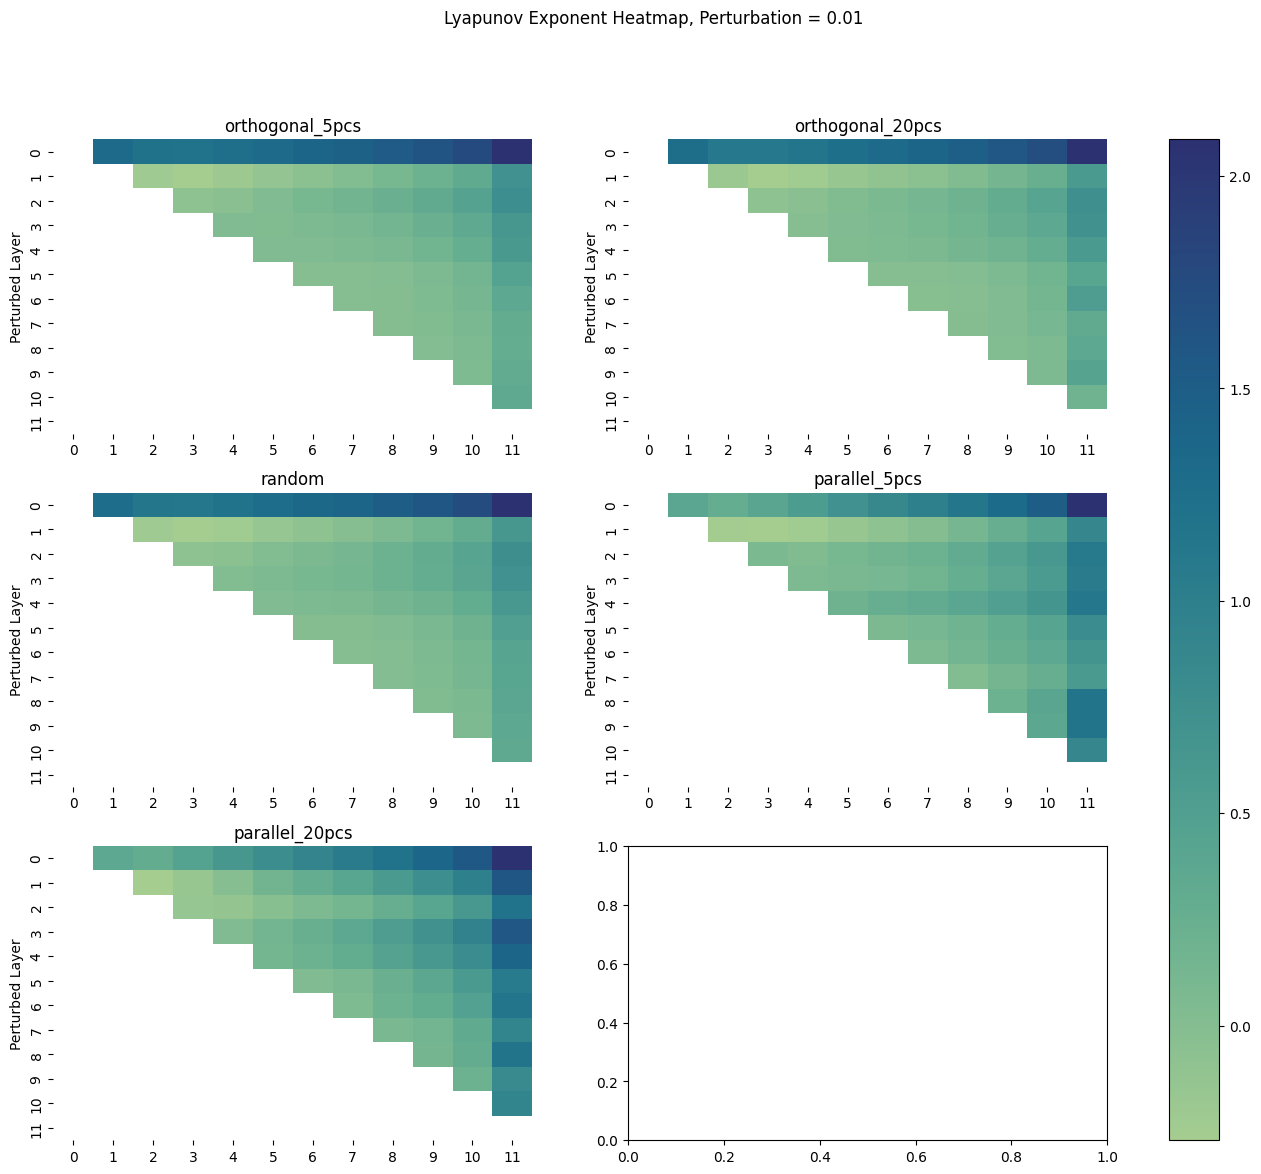

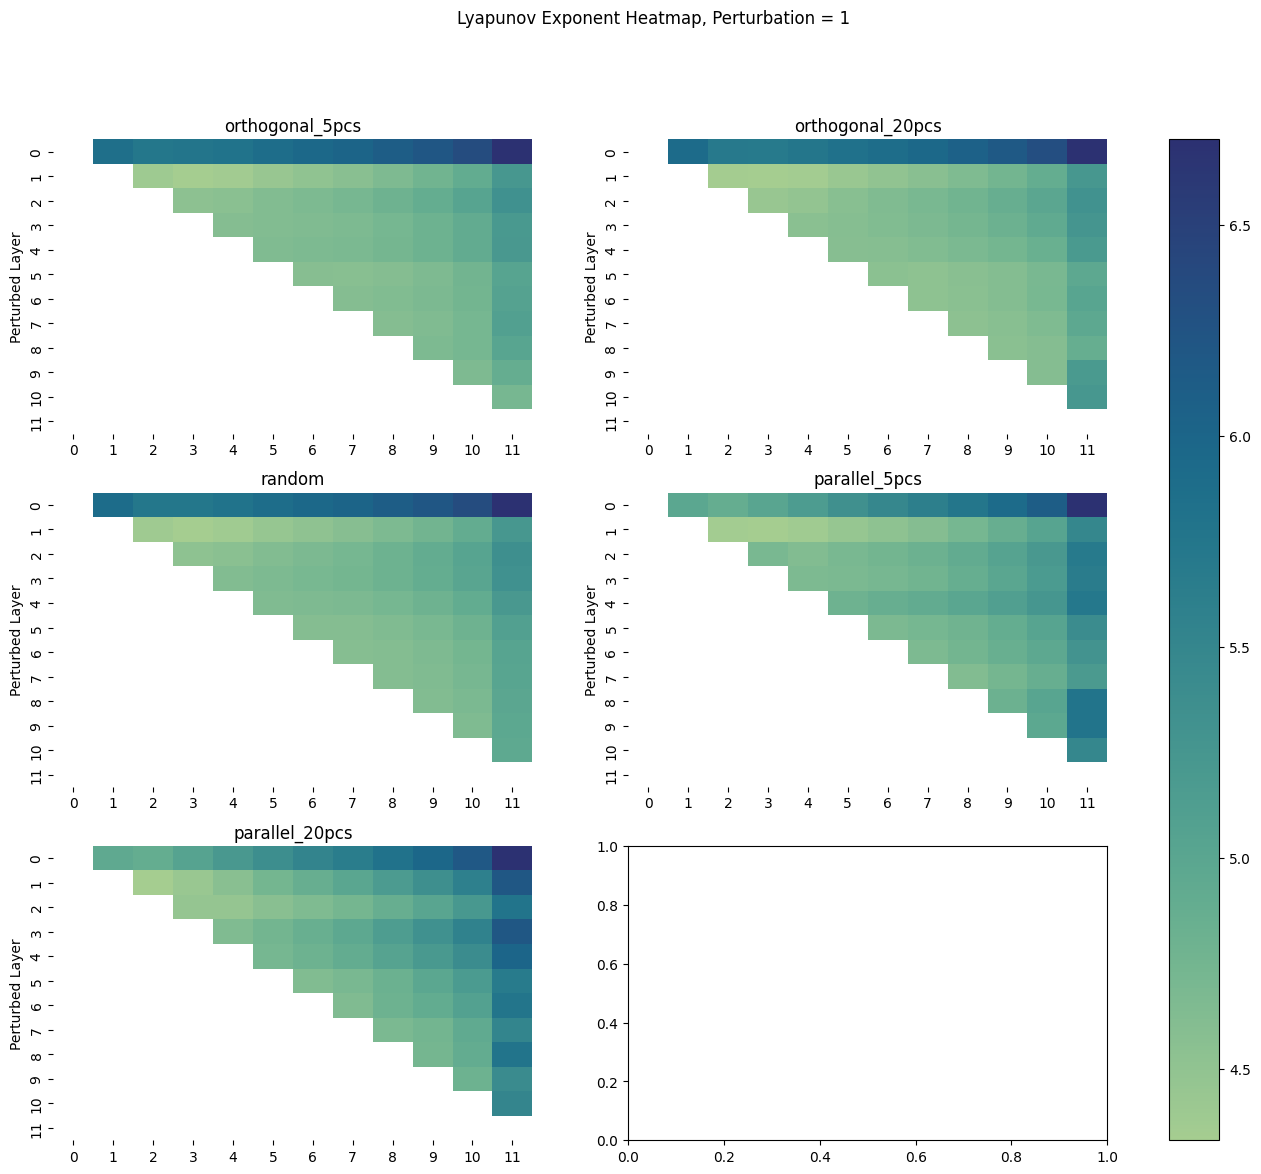

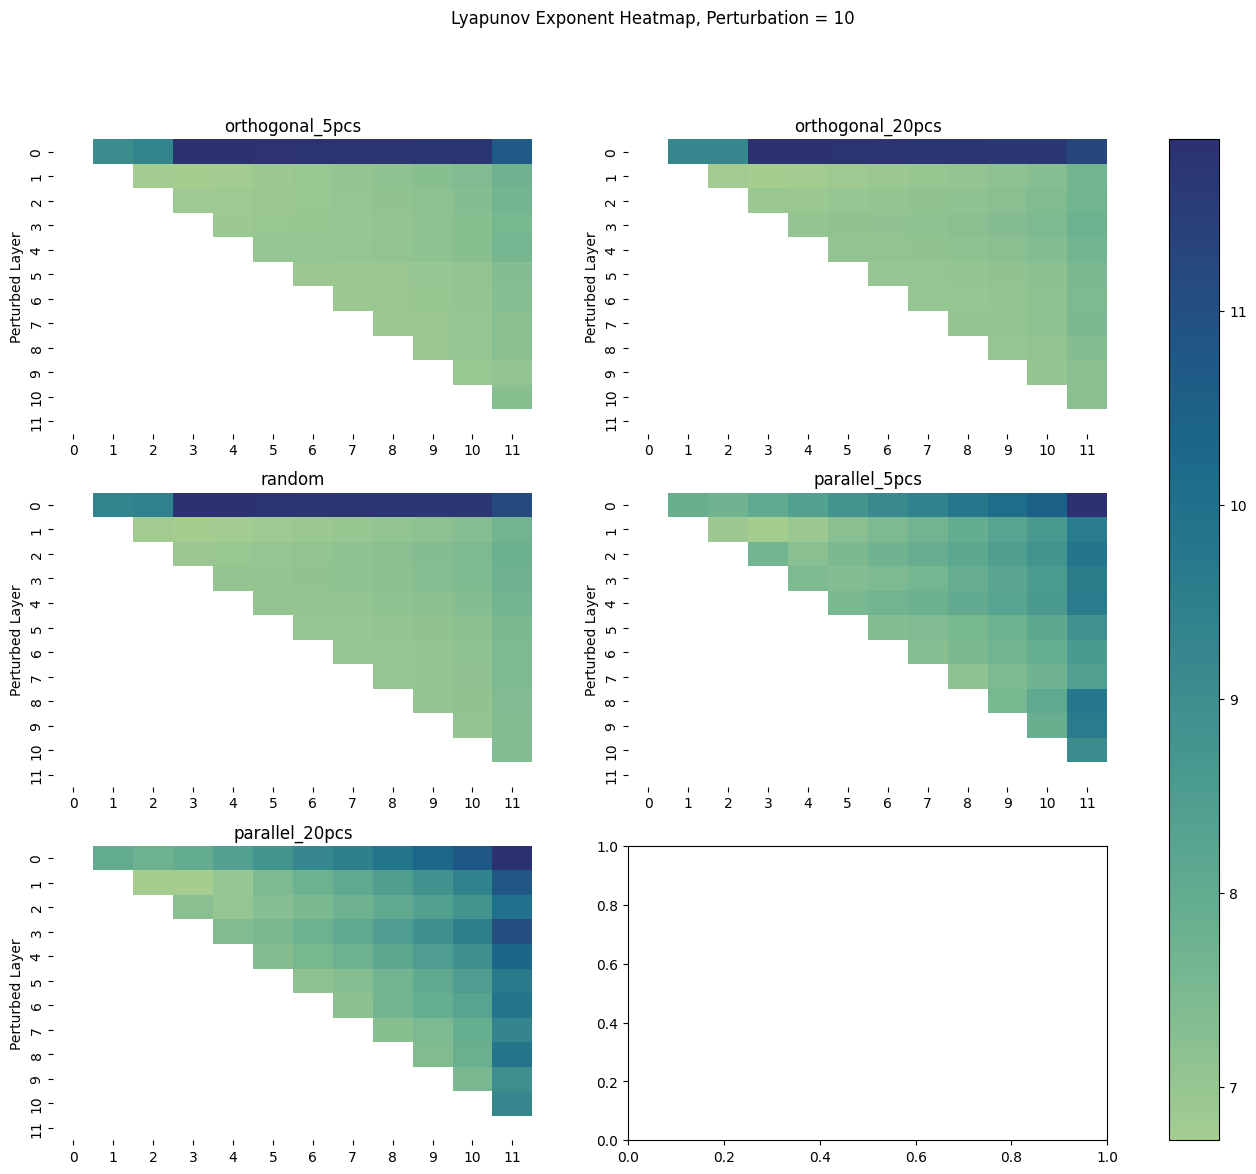

In [8]:
layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
where = "before_attn"
print("PERTUBATION IS IN RESIDUAL BEFORE ATTENTION LAYER")
plot_lyapunov(layers, where)
plot_logit_divergence(layers, where)
plot_heatmap(layers, where)

where = "before_mlp"
print("PERTUBATION IS IN RESIDUAL BEFORE MLP LAYER")
plot_lyapunov(layers, where)
plot_logit_divergence(layers, where)
plot_heatmap(layers, where)


#### Plot PCAs, still working on this

In [22]:
perturbation_loc = "before_mlp"
pertubation_size = 1
name = "orthogonal_5pcs"
layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11]
activations = torch.zeros((1, 12, 768))
activation =  torch.load(f"/om2/user/jackking/MyData/dynamics/activations/{perturbation_loc}/perturb_{pertubation_size}/{name}/1_perturbed_activations.pt")
for act in activation:
    print(act)
for layer in layers:
    activations[0, layer, :] = torch.load(f"/om2/user/jackking/MyData/dynamics/activations/{perturbation_loc}/perturb_{pertubation_size}/{name}/{layer}_perturbed_activations.pt")
num_layers = len(activations[0])
max_token_num = 10
pcas = get_pcas(activations, num_layers, max_token_num)
plot_pcas(pcas, activations)

12
12
12
12
12
12


TypeError: can't assign a list to a torch.FloatTensor

#### Print completion results

In [ ]:
perturbation_loc = ""
pertubation_size = 1
name = "orthogonal_5pcs"
completions = pd.read_csv(f"/om2/user/jackking/modular_transformers/modular_transformers/dynamics/{where}/perturb_{pertubation_size}/{name}/bigram_results.csv", index_col=0)


### Bigram analysis

In [ ]:
def softmax(logits):
    """Apply the softmax function to convert logits to probabilities."""
    e_x = np.exp(logits - np.max(logits))
    return e_x / e_x.sum(axis=0)

def entropy_of_logits(logits):
    """Calculate the entropy of a set of logits."""
    probabilities = softmax(logits)
    entropy = -np.sum(probabilities * np.log(probabilities + 1e-9))  # Adding a small constant to avoid log(0)
    return entropy

In [ ]:
#find the to 10 most bigrams with the highest or lowest entropy
def get_top_bigrams(model, bigram_tokens, highest=True):
    top_bigrams = []
    for bigram in bigram_tokens:
        input = bigram.to(device)
        output = model(input)
        logits = output.logits[-1, :].detach().cpu().numpy()
        entropy = entropy_of_logits(logits)
        top_bigrams.append((entropy, bigram))
    top_bigrams.sort(key=lambda x: x[0], reverse=highest)
    return top_bigrams

In [ ]:
bigrams = get_top_bigrams(orig_model, bigram_tokens)
#convert to text
bigram = [(b[0], tokenizer.decode(b[1].squeeze())) for b in bigrams[-15:]]
for b in bigram:
    print(b[1])